## import all needed liberary

In [836]:
import skimage.io as io

# Show the figures / plots inside the notebook
%matplotlib inline
from skimage.color import rgb2gray,rgb2hsv
from skimage.exposure import equalize_adapthist 
from skimage import filters
from skimage import measure
from skimage.draw import polygon
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
from skimage.draw import rectangle
import imutils
from skimage.exposure import histogram
from matplotlib.pyplot import bar
import ArabicOcr


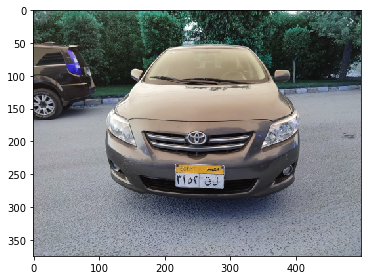

In [871]:
img_data1 =cv2.imread("dataset\data13.jpeg")
img_data1 = imutils.resize(img_data1 , width = 500)
io.imshow(img_data1)


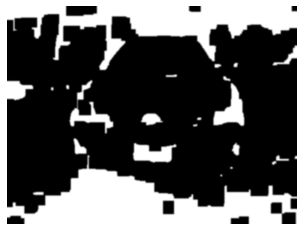

[[112  88  89 ...  24  46 105]
 [ 93  88  75 ...  25  41  89]
 [ 99  90  76 ...  49  37  40]
 ...
 [154 140 153 ... 158 154 151]
 [151 157 159 ... 131 113 124]
 [160 166 167 ... 148 127 108]]


In [872]:
def show_image (img):
    fig = plt.figure()
    plt.gray()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def image_preprocessing (img):
    '''
        in this function we are going to applying different preprocessing 
        techniques in the input image 

        prams:
                img 
    '''
    '''
   
    '''
    # initialize the rectangular and square kernels to be applied to the image,
    # then initialize the list of license plate regions
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 3))
    squareKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    

    # convert the image to grayscale, and apply the blackhat operation
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)

    # find regions in the image that are light
    light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, squareKernel)
    light = cv2.threshold(light, 50, 255, cv2.THRESH_BINARY)[1]

    # compute the Scharr gradient representation of the blackhat image and s
    gradX = cv2.Sobel(blackhat,ddepth = cv2.CV_32F,dx = 1, dy = 0, ksize = -1)
    
    gradX = np.absolute(gradX)
    
    # scale theresulting image into the range [0, 255]
    (minVal, maxVal) = (np.min(gradX), np.max(gradX))
    gradX = (255 * ((gradX - minVal) / (maxVal - minVal))).astype("uint8")

    # blur the gradient representation, apply a closing operating, and threshold the
    # image using Otsu's method
    gradX = cv2.GaussianBlur(gradX, (9, 9), 0)
    gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
    thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # perform a series of erosions and dilations on the image
    thresh = cv2.erode(thresh, None, iterations = 2)
    thresh = cv2.dilate(thresh, None, iterations = 3)

    # take the bitwise 'and' between the 'light' regions of the image, then perform
    # another series of erosions and dilations
    thresh = cv2.bitwise_and(thresh, thresh, mask = light)
    thresh = cv2.dilate(thresh, None, iterations =6)
    thresh = cv2.erode(thresh, None, iterations = 8)
    blur = cv2.GaussianBlur(thresh,(5,5),0)

    return blur , gray
   

w = img_data1.shape[0]
h = img_data1.shape[1]
preprocessed_img  , gray_img= image_preprocessing(img_data1)
show_image(preprocessed_img)
io.imsave('result1.jpg' , preprocessed_img)
print(gray_img)

In [883]:
def ratioCheck (w , h):
    #getting area and aspect ratio for 
    area = w* h
    aspect_ratio = w/h 
    return  (1.7< aspect_ratio < 4.5 and 1000<area < 4850)
    

In [884]:
def checkChannels(window , w, h):
    #getting average value for each channel 
    avg_red_ch = np.sum(window[:,:,0])/ (w*h)  
    avg_green_ch = np.sum(window[:,:,1])/ (w*h)   
    avg_blue_ch = np.sum(window[:,:,2])/ (w*h) 
    return  avg_red_ch >100 and avg_green_ch>100 and avg_blue_ch>80 
    

In [885]:
def plate_criteria(window , w ,h):
        return  ratioCheck(w,h) and check_channels(window ,w , h)

        

In [886]:
def plates_re(edge_img , img ):
    
    # getting contours form edge image
    cnts, _ = cv2.findContours(edge_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    plates = []
    #looping over the contours to get possible plates 
    for i, c in enumerate(cnts):
        x,y,w,h = cv2.boundingRect(c)
        window =img[y:y+h, x:x+w]  
        
        #check plate criteria for each contour 
        if ( plate_criteria(window , w ,h)  ):
                plate = img[y-7:y+h+7, x-1:x+w+1]
                if plate.shape[0] and plate.shape[1] :
                    plates.append(plate)

    #writing plate in scannedplates file                     
    for i, plate in enumerate(plates):
                cv2.imwrite(f'Scannedplates/Plate{i}.jpg', plate )

    return   plates

plates= edge_img_processing(preprocessed_img , img_data1)
